# Prepare Dataset
> Note: Colab only

In [4]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [9]:
!cp -r /content/drive/MyDrive/Capstone/Eye-Infection-Dataset/ .
!mv ./Eye-Infection-Dataset ./dataset
!rm ./dataset/LICENSE.md
!mkdir export

mkdir: cannot create directory ‘export’: File exists


# Setup

In [12]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from io import BytesIO
from ipywidgets import widgets
from google.colab import files

In [13]:
DATASET_PATH = './dataset'
CLASSES = sorted(os.listdir(DATASET_PATH))
IMAGE_SIZE=(150, 150)

# Data Processing

In [14]:
train_ds, val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    image_size=IMAGE_SIZE,
    label_mode='categorical',
    validation_split=0.2,
    subset='both',
    batch_size=32,
    seed=8
)

Found 615 files belonging to 3 classes.
Using 492 files for training.
Using 123 files for validation.


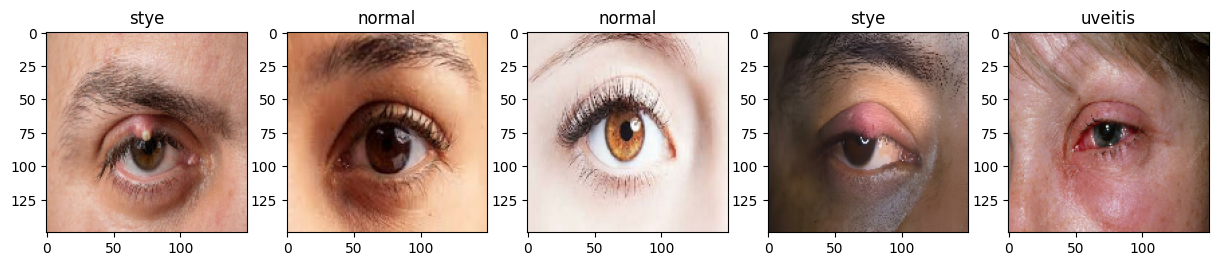

In [15]:
imgs = list(train_ds.take(5))[0]

# print(imgs)

plot, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 15))

for i, ax in enumerate(axes):
  img = tf.keras.utils.array_to_img(imgs[0][i])
  lbl = CLASSES[np.argmax(imgs[1][i].numpy())]

  ax.title.set_text(lbl)
  ax.imshow(img)

In [16]:
def preprocess_image(image):
  image = tf.cast(image, tf.float32)
  image /= 255.0
  return image

In [17]:
train_ds = train_ds.map(lambda x, y: (preprocess_image(x), y))
val_ds = val_ds.map(lambda x, y: (preprocess_image(x), y))

In [18]:
train_ds_pref = train_ds.cache().shuffle(64).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds_pref = val_ds.cache().shuffle(64).prefetch(buffer_size=tf.data.AUTOTUNE)

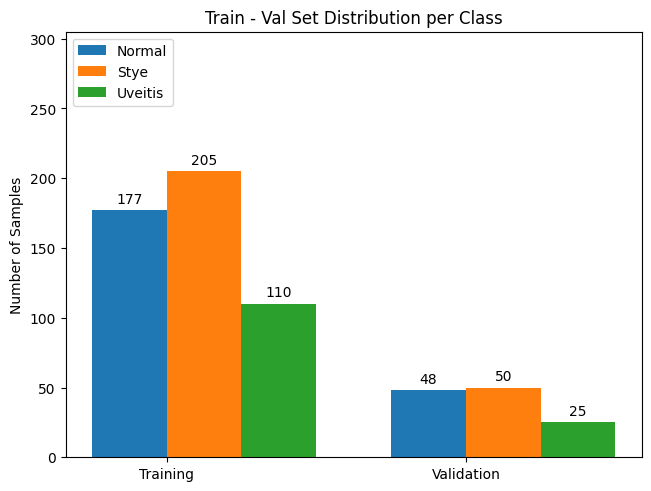

In [19]:
# Count the number of samples in the train and validation datasets for each class
train_normal_count = 0
train_stye_count = 0
train_uveitis_count = 0

val_normal_count = 0
val_stye_count = 0
val_uveitis_count = 0

# Loop through train_ds to calculate the number of samples per class
for images, labels in train_ds:
    train_normal_count += np.sum(labels[:, 0])
    train_stye_count += np.sum(labels[:, 1])
    train_uveitis_count += np.sum(labels[:, 2])

# Loop through val_ds to calculate the number of samples per class
for images, labels in val_ds:
    val_normal_count += np.sum(labels[:, 0])
    val_stye_count += np.sum(labels[:, 1])
    val_uveitis_count += np.sum(labels[:, 2])

# Data for visualization
split = ("Training", "Validation")
num_set = {
    'Normal': (train_normal_count, val_normal_count),
    'Stye': (train_stye_count, val_stye_count),
    'Uveitis': (train_uveitis_count, val_uveitis_count),
}

# Visualization
x = np.arange(len(split))
width = 0.25
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in num_set.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Adding labels, title, and adjusting x-axis labels
ax.set_ylabel('Number of Samples')
ax.set_title('Train - Val Set Distribution per Class')
ax.set_xticks(x + (width / 2), split)
ax.legend(loc='upper left', ncols=1)
ax.set_ylim(0, max(train_normal_count, train_stye_count, train_uveitis_count,
                   val_normal_count, val_stye_count, val_uveitis_count) + 100)

plt.show()


# Model Setup

In [20]:
class CustomCallback(tf.keras.callbacks.Callback):
  def __init__(self):
    super(CustomCallback, self).__init__()
    self.prev_acc = 0.0

  def on_epoch_end(self, epoch, logs=None):
    self.prev_acc = logs['accuracy']

    # Early stop when there is no accuracy or loss improvement
    if epoch > 30 and self.prev_acc < 0.5:
      self.model.stop_training = True
      print("\nStopped the training because there is no improvement")

    # Early stop when the model has achieved the desired accuracy
    if (logs['loss'] < 0.2 and logs['val_loss'] < 0.2) and (logs['accuracy'] >= 0.97 and logs['val_accuracy'] >= 0.97):
      self.model.stop_training = True
      print("\nAlready met the desired accuracy")

In [54]:
tf.keras.backend.clear_session()

In [55]:
model_aug = tf.keras.models.Sequential([
    tf.keras.Input(shape=IMAGE_SIZE + (3,)),
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom((0.0, 0.2), (0.0, 0.2), fill_mode="nearest", seed=16)
])

In [56]:
model = tf.keras.models.Sequential([
    model_aug,
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Conv2D(256, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Conv2D(512, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.1), activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax'),
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 15, 15, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 5, 5, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,619,203 (9.99 MB)

 Trainable params: 2,619,203 (9.99 MB)

 Non-trainable params: 0 (0.00 B)

# Model Training

In [57]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate= 1E-4),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

model_obj = model.fit(
    train_ds,
    epochs=200,
    batch_size=16,
    validation_data=val_ds,
    callbacks=[CustomCallback()]
)

Epoch 1/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.3498 - loss: 80.9956 - val_accuracy: 0.4065 - val_loss: 75.1047
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.4185 - loss: 73.3054 - val_accuracy: 0.4553 - val_loss: 67.8955
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.4527 - loss: 66.2572 - val_accuracy: 0.4065 - val_loss: 61.3507
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.4180 - loss: 59.8485 - val_accuracy: 0.4878 - val_loss: 55.3632
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.4948 - loss: 54.0127 - val_accuracy: 0.4797 - val_loss: 49.9287
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.5212 - loss: 48.6826 - val_accuracy: 0.4634 - val_loss: 44.9985
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.5372 - loss: 43.8582 - val_accuracy: 0.4553 - val_loss: 40.6121
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.5465 - loss: 39.5161 -

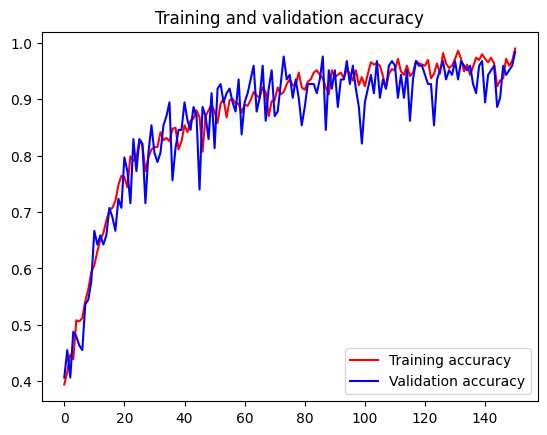

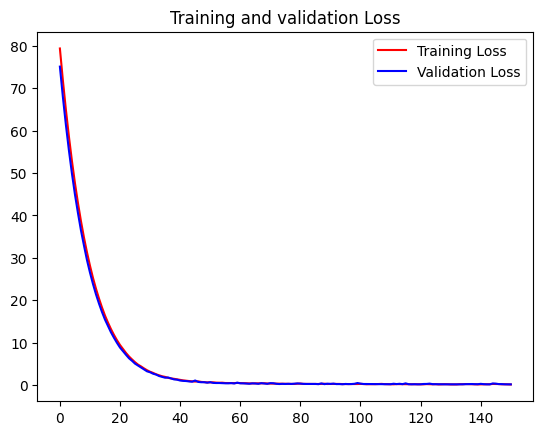

In [59]:
acc = model_obj.history['accuracy']
val_acc = model_obj.history['val_accuracy']
loss = model_obj.history['loss']
val_loss = model_obj.history['val_loss']

epochs = range(len(acc))

# Plot the training and validation accuracies for each epoch
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.show()

# Plot the training and validation loss for each epoch
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation Loss')
plt.legend(loc=0)
plt.show()

# Model Tuning (Experiment)
> This section is only for experiment. Therefore, optional. Make sure you haven't compile or train the model yet!

In [87]:
# Learning rate scheduler

tf.keras.backend.clear_session()

model_aug = tf.keras.models.Sequential([
    tf.keras.Input(shape=IMAGE_SIZE + (3,)),
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom((0.0, 0.2), (0.0, 0.2), fill_mode="nearest", seed=16)
])

model_tn = tf.keras.models.Sequential([
    model_aug,
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Conv2D(256, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Conv2D(512, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.1), activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax'),
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10 ** (epoch/60))


In [88]:
class LearningRateLogger(tf.keras.callbacks.Callback):
    def __init__(self):
        super(LearningRateLogger, self).__init__()
        self.lr_list = []
        self.acc_list = []
        self.val_acc_list = []
        self.loss_list = []
        self.val_loss_list = []

    def on_epoch_end(self, epoch, logs=None):
        # Log learning rate, accuracy, and loss
        lr = self.model.optimizer.learning_rate.numpy()  # Perbaikan di sini
        self.lr_list.append(lr)
        self.acc_list.append(logs['accuracy'])
        self.val_acc_list.append(logs['val_accuracy'])
        self.loss_list.append(logs['loss'])
        self.val_loss_list.append(logs['val_loss'])


In [89]:
# Initialize the logger
lr_logger = LearningRateLogger()

model_tn.compile(
    loss= tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

model_obj_tn = model_tn.fit(
    train_ds,
    epochs=200,
    batch_size=16,
    validation_data=val_ds,
    callbacks=[lr_schedule, lr_logger]
)

Epoch 1/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.3233 - loss: 83.0458 - val_accuracy: 0.3902 - val_loss: 82.9824 - learning_rate: 1.0000e-06
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.3419 - loss: 82.9637 - val_accuracy: 0.3902 - val_loss: 82.8966 - learning_rate: 1.0391e-06
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.3431 - loss: 82.8767 - val_accuracy: 0.3902 - val_loss: 82.8076 - learning_rate: 1.0798e-06
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.3720 - loss: 82.7866 - val_accuracy: 0.3902 - val_loss: 82.7152 - learning_rate: 1.1220e-06
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.4047 - loss: 82.6925 - val_accuracy: 0.3984 - val_loss: 82.6193 - learning_rate: 1.1659e-06
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.3779 - loss: 82.5972 - val_accuracy: 0.4553 - val_loss: 82.5201 - learning_rate: 1.2115e-06
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/ste

In [90]:
def demo_augmentation(sample_image, model, num_aug):
    '''Takes a single image array, then uses a model to generate num_aug transformations'''

    # Instantiate preview list
    image_preview = []

    # Convert input image to a PIL image instance
    sample_image_pil = tf.keras.utils.array_to_img(sample_image)

    # Append the result to the list
    image_preview.append(sample_image_pil)

    # Apply the image augmentation and append the results to the list
    for i in range(num_aug):
        sample_image_aug = model(tf.expand_dims(sample_image, axis=0))
        sample_image_aug_pil = tf.keras.utils.array_to_img(tf.squeeze(sample_image_aug))
        image_preview.append(sample_image_aug_pil)

    # Instantiate a subplot
    fig, axes = plt.subplots(1, num_aug + 1, figsize=(12, 12))

    # Preview the images.
    for index, ax in enumerate(axes):
        ax.imshow(image_preview[index])
        ax.set_axis_off()

        if index == 0:
            ax.set_title('original')
        else:
            ax.set_title(f'augment {index}')

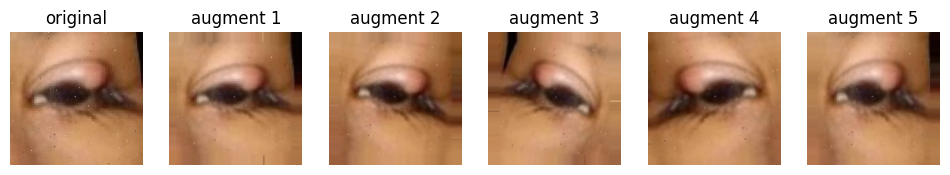

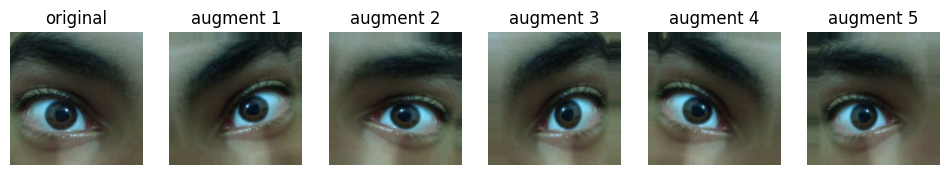

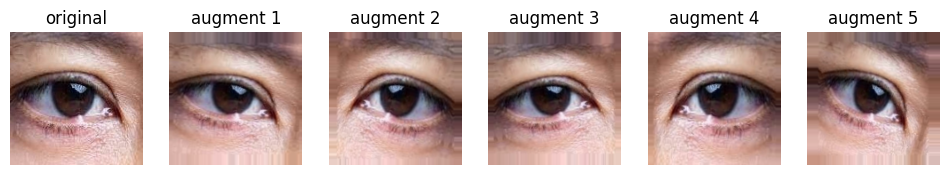

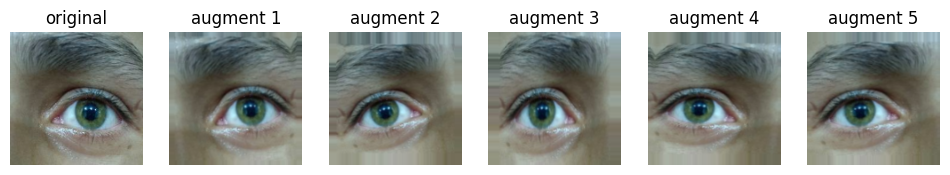

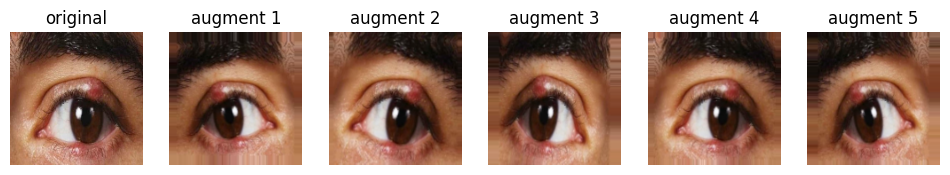

In [91]:
sample_batch = list(train_ds.take(1))[0][0]

for i in range(5):
  demo_augmentation(sample_batch[i], model_aug, 5)

# Model Evaluation

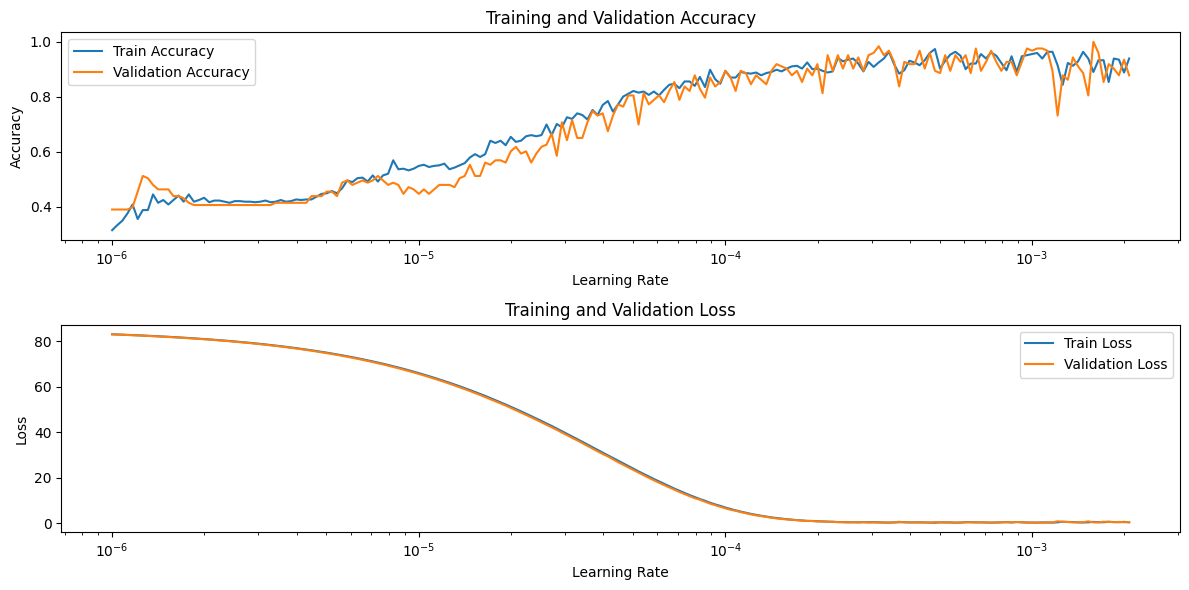

In [92]:
plt.figure(figsize=(12, 6))

# Plot for Accuracy
plt.subplot(2, 1, 1)
plt.plot(lr_logger.lr_list, lr_logger.acc_list, label='Train Accuracy')
plt.plot(lr_logger.lr_list, lr_logger.val_acc_list, label='Validation Accuracy')
plt.xscale('log')  # Log scale for learning rate
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot for Loss
plt.subplot(2, 1, 2)
plt.plot(lr_logger.lr_list, lr_logger.loss_list, label='Train Loss')
plt.plot(lr_logger.lr_list, lr_logger.val_loss_list, label='Validation Loss')
plt.xscale('log')  # Log scale for learning rate
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [93]:
# Find the best learning rate based on the metrics
best_train_acc_lr = lr_logger.lr_list[lr_logger.acc_list.index(max(lr_logger.acc_list))]
best_val_acc_lr = lr_logger.lr_list[lr_logger.val_acc_list.index(max(lr_logger.val_acc_list))]
best_train_loss_lr = lr_logger.lr_list[lr_logger.loss_list.index(min(lr_logger.loss_list))]
best_val_loss_lr = lr_logger.lr_list[lr_logger.val_loss_list.index(min(lr_logger.val_loss_list))]

# Display the results for each metric
print(f"Best Train Accuracy Learning Rate: {best_train_acc_lr:.1e}")
print(f"Best Validation Accuracy Learning Rate: {best_val_acc_lr:.1e}")
print(f"Best Train Loss Learning Rate: {best_train_loss_lr:.1e}")
print(f"Best Validation Loss Learning Rate: {best_val_loss_lr:.1e}")
print('='*50)

# Find and print the metrics for the best learning rate
for lr in [best_train_acc_lr, best_val_acc_lr, best_train_loss_lr, best_val_loss_lr]:
    lr_index = lr_logger.lr_list.index(lr)
    print(f"Learning Rate: {lr:.1e}")
    print(f" - Best Train Accuracy: {lr_logger.acc_list[lr_index]}")
    print(f" - Best Validation Accuracy: {lr_logger.val_acc_list[lr_index]}")
    print(f" - Best Train Loss: {lr_logger.loss_list[lr_index]}")
    print(f" - Best Validation Loss: {lr_logger.val_loss_list[lr_index]}")
    print()



Best Train Accuracy Learning Rate: 4.8e-04
Best Validation Accuracy Learning Rate: 1.6e-03
Best Train Loss Learning Rate: 4.8e-04
Best Validation Loss Learning Rate: 1.0e-03
Learning Rate: 4.8e-04
 - Best Train Accuracy: 0.9735772609710693
 - Best Validation Accuracy: 0.8943089246749878
 - Best Train Loss: 0.18632063269615173
 - Best Validation Loss: 0.4381265938282013

Learning Rate: 1.6e-03
 - Best Train Accuracy: 0.8902438879013062
 - Best Validation Accuracy: 1.0
 - Best Train Loss: 0.5381042957305908
 - Best Validation Loss: 0.3343876600265503

Learning Rate: 4.8e-04
 - Best Train Accuracy: 0.9735772609710693
 - Best Validation Accuracy: 0.8943089246749878
 - Best Train Loss: 0.18632063269615173
 - Best Validation Loss: 0.4381265938282013

Learning Rate: 1.0e-03
 - Best Train Accuracy: 0.9593495726585388
 - Best Validation Accuracy: 0.9756097793579102
 - Best Train Loss: 0.22378365695476532
 - Best Validation Loss: 0.18422241508960724



In [94]:
tf.keras.backend.clear_session()

model_aug = tf.keras.models.Sequential([
    tf.keras.Input(shape=IMAGE_SIZE + (3,)),
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom((0.0, 0.2), (0.0, 0.2), fill_mode="nearest", seed=16)
])

model_tn = tf.keras.models.Sequential([
    model_aug,
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Conv2D(256, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Conv2D(512, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.1), activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax'),
])



model_tn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate= 1.0e-03),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

model_obj = model_tn.fit(
    train_ds,
    epochs=200,
    batch_size=16,
    validation_data=val_ds,
    callbacks=[CustomCallback()]
)

Epoch 1/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.4133 - loss: 66.1387 - val_accuracy: 0.3902 - val_loss: 27.0608
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.3453 - loss: 20.4271 - val_accuracy: 0.3902 - val_loss: 6.7637
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.4884 - loss: 5.0061 - val_accuracy: 0.3984 - val_loss: 1.8857
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.4627 - loss: 1.5683 - val_accuracy: 0.4797 - val_loss: 1.1095
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.4467 - loss: 1.1047 - val_accuracy: 0.4472 - val_loss: 1.0542
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.5241 - loss: 1.0397 - val_accuracy: 0.4065 - val_loss: 1.0986
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.3778 - loss: 1.1052 - val_accuracy: 0.5285 - val_loss: 0.9328
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.5727 - loss: 0.9404 - val_accuracy

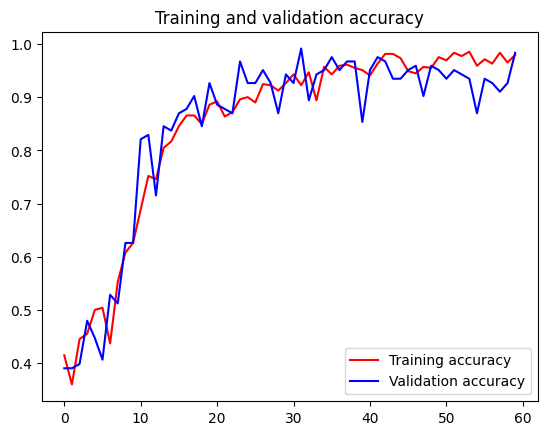

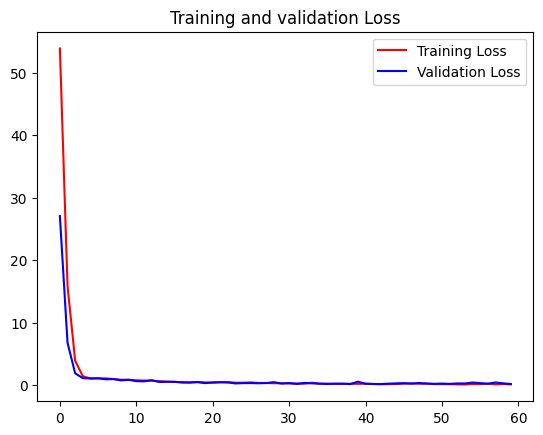

In [95]:


acc = model_obj.history['accuracy']
val_acc = model_obj.history['val_accuracy']
loss = model_obj.history['loss']
val_loss = model_obj.history['val_loss']

epochs = range(len(acc))

# Plot the training and validation accuracies for each epoch
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.show()

# Plot the training and validation loss for each epoch
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation Loss')
plt.legend(loc=0)
plt.show()

# Testing

Saving images (2).jpg to images (2) (1).jpg
Probability: [4.6915127e-05 9.3969833e-03 9.9055618e-01]
Prediction: uveitis



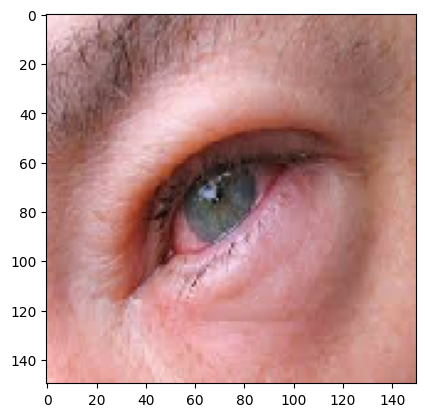

In [99]:
uploaded = files.upload()

for f in uploaded.keys():
  img = tf.keras.preprocessing.image.load_img(f, target_size=IMAGE_SIZE)

  plt.imshow(img)

  img = tf.keras.utils.img_to_array(img)
  img /= 255.0
  img = tf.expand_dims(img, axis=0)

  prediction = model.predict(img, verbose=0)[0]

  print(f'Probability: {prediction}')
  print(f'Prediction: {CLASSES[np.argmax(prediction)]}\n')

# Model Export

In [101]:
model.save("export/model.keras")